#### **Updating State - LangGraph**

You can go far with this simple state, but if you want to define complex behavior without relying on the message list, you can add additional fields to the state. Here we will demonstrate a new scenario, in which the chatbot is using its search tool to find specific information, and forwarding them to a human for review.

In [27]:
# Installing the required libraries
import os
from dotenv import load_dotenv
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool,InjectedToolCallId
from langgraph.types import Command,interrupt
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

In [28]:
# Setting the environment variables
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [29]:
# Langgraph State
class State(TypedDict):
    messages: Annotated[list,add_messages]
    birthday: str
    name: str

In [30]:
# Using Command to update states inside the tool
@tool
def human_assistance(name:str, birthday:str, tool_call_id:Annotated[str,InjectedToolCallId])->str:
    """Request assistance from human"""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"
        
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [31]:
tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
# llm = ChatGroq(model_name="llama-3.3-70b-versatile")
llm = ChatGroq(model_name="llama3-8b-8192")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # print("messages",message,"\n Total tool calls : ",len(message.tool_calls))
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

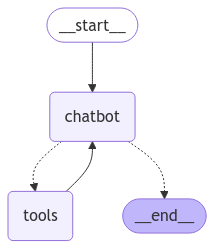

In [32]:
graph

In [33]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "hrishi6"}}

# response = graph.invoke({"messages": [{"role": "user", "content": user_input}]},
#     config,)

events = graph.stream({"messages": [{"role": "user", "content": user_input}]},config,stream_mode='values')
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_edsq)
 Call ID: call_edsq
  Args:
    name: LangGraph
    birthday: N/A


In [24]:
# response

In [34]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

In [35]:
# response = graph.invoke(human_command,config)
events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_edsq)
 Call ID: call_edsq
  Args:
    name: LangGraph
    birthday: N/A
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_8fvj)
 Call ID: call_8fvj
  Args:
    query: when was LangGraph released
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://github.com/langchain-ai/langgraph/releases", "content": "Releases · langchain-ai/langgraph · GitHub Search code, repositories, users, issues, pull requests... Releases: langchain-ai/langgraph Releases · langchain-ai/langgraph langgraph: release 0.2.70 (#3341) langgraph: add agent name to AI messages i

In [36]:
# response

In [37]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.', additional_kwargs={}, response_metadata={}, id='721f9663-8803-45fe-882a-154e043f1953'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_edsq', 'function': {'arguments': '{"name":"LangGraph","birthday":"N/A"}', 'name': 'human_assistance'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 1077, 'total_tokens': 1160, 'completion_time': 0.069209602, 'prompt_time': 0.135793937, 'queue_time': 0.025755609999999984, 'total_time': 0.205003539}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c6105316-4173-4ddf-b25f-6c9fa55fa851-0', tool_calls=[{'name': 'human_assistance', 'args': {'name': 'LangGraph', 'birthday': 'N/A'}, 'id': 'call_edsq', 'type': 'tool_call'}], usage_metadat

In [40]:
{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'birthday': 'Jan 17, 2024', 'name': 'LangGraph'}